In [1]:
# Installations
!pip install fastdtw scikit-image
!pip install jiwer
!pip install torch_geometric   
!pip install Levenshtein
# !pip install faiss-gpu
# Core imports
import os, pickle, csv, json
import numpy as np, pandas as pd
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown 
import math
import random

# Image processing
from skimage.filters import threshold_sauvola
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops
from skimage.util import invert
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from jiwer import wer, cer
import Levenshtein
 
# PyTorch
import torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as F
import torchvision, torchvision.models as tv_models
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542096 sha256=6df9d092541a80d1ffba4dc23c1f5f8bade1bd80e3d322c947d860398b51b82c
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 5.5 MB/s eta 0:00:00


In [2]:
import os
import pickle
import csv
from PIL import Image

# Combine all datasets into one dictionary
ALL_DATASETS = {
    'CROHME2014': '/kaggle/input/hmer-data/HMER Dataset/CROHME/crohme/2014',
    'CROHME2016': '/kaggle/input/hmer-data/HMER Dataset/CROHME/crohme/2016',
    'CROHME2019': '/kaggle/input/hmer-data/HMER Dataset/CROHME/crohme/2019',
}

BASE_OUT = '/kaggle/working/hmer_data'
os.makedirs(BASE_OUT, exist_ok=True)

print(f"\n=== Processing All Datasets ===\nSaving to: {BASE_OUT}\n")

for dataset_name, base_in in ALL_DATASETS.items():
    print(f"\nProcessing dataset: {dataset_name}")
    
    dataset_out_dir = os.path.join(BASE_OUT, dataset_name)
    OUT_IMG_DIR = os.path.join(dataset_out_dir, 'images')
    OUT_CSV = os.path.join(dataset_out_dir, 'annotations.csv')
    os.makedirs(OUT_IMG_DIR, exist_ok=True)

    with open(os.path.join(base_in, 'images.pkl'), 'rb') as f:
        imgs_dict = pickle.load(f)
    with open(os.path.join(base_in, 'caption.txt'), 'r', encoding='utf8') as f:
        lines = f.read().splitlines()

    processed_count = 0
    with open(OUT_CSV, 'w', newline='', encoding='utf8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['file', 'latex'])

        for line in lines:
            parts = line.strip().split(None, 1)
            if len(parts) != 2:
                continue
            fname, latex = parts
            arr = imgs_dict.get(fname)
            if arr is None:
                continue
            if arr.dtype != np.uint8:
                arr = (255 * (1 - (arr - arr.min()) / (arr.max() - arr.min()))).astype(np.uint8)

            outname = f"{dataset_name}_{fname}.png"
            Image.fromarray(arr).save(os.path.join(OUT_IMG_DIR, outname))
            writer.writerow([outname, latex])
            processed_count += 1

    print(f"✓ {processed_count} image-caption pairs processed.")
    print(f"→ Images saved to: {OUT_IMG_DIR}")
    print(f"→ Annotations saved to: {OUT_CSV}")



=== Processing All Datasets ===
Saving to: /kaggle/working/hmer_data


Processing dataset: CROHME2014
✓ 986 image-caption pairs processed.
→ Images saved to: /kaggle/working/hmer_data/CROHME2014/images
→ Annotations saved to: /kaggle/working/hmer_data/CROHME2014/annotations.csv

Processing dataset: CROHME2016
✓ 1147 image-caption pairs processed.
→ Images saved to: /kaggle/working/hmer_data/CROHME2016/images
→ Annotations saved to: /kaggle/working/hmer_data/CROHME2016/annotations.csv

Processing dataset: CROHME2019
✓ 1199 image-caption pairs processed.
→ Images saved to: /kaggle/working/hmer_data/CROHME2019/images
→ Annotations saved to: /kaggle/working/hmer_data/CROHME2019/annotations.csv



=== Showing 4 samples from CROHME2014 ===


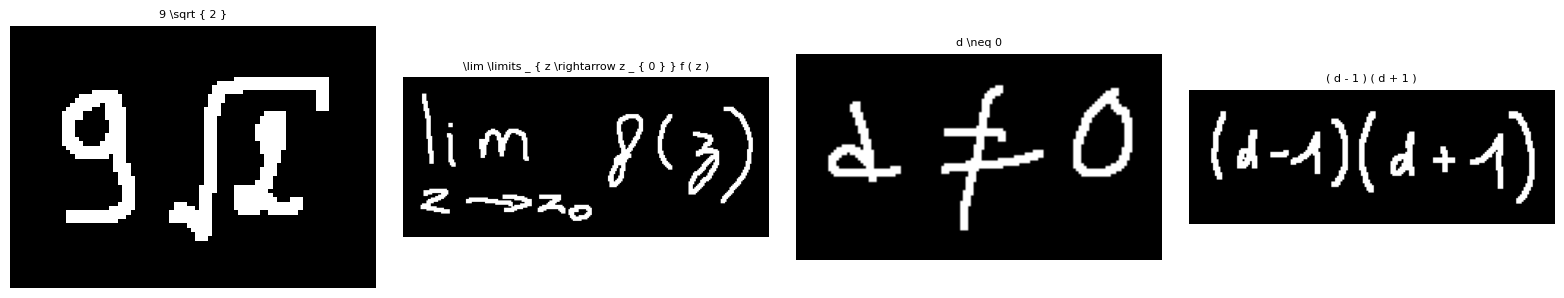


=== Showing 4 samples from CROHME2016 ===


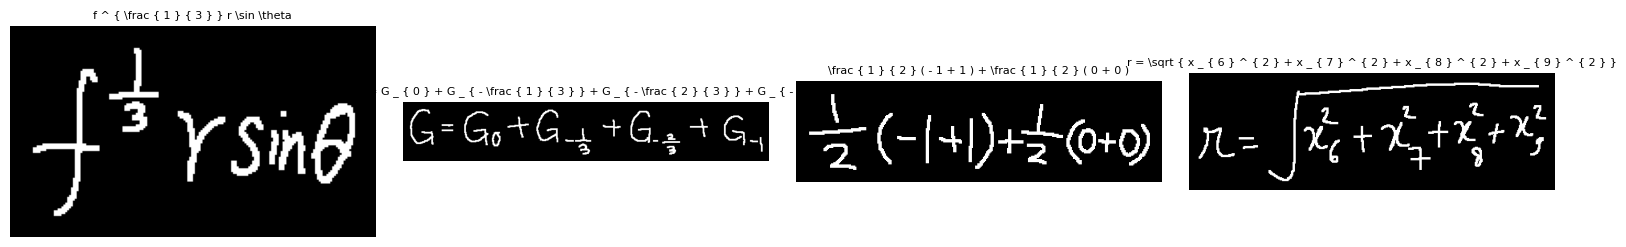


=== Showing 4 samples from CROHME2019 ===


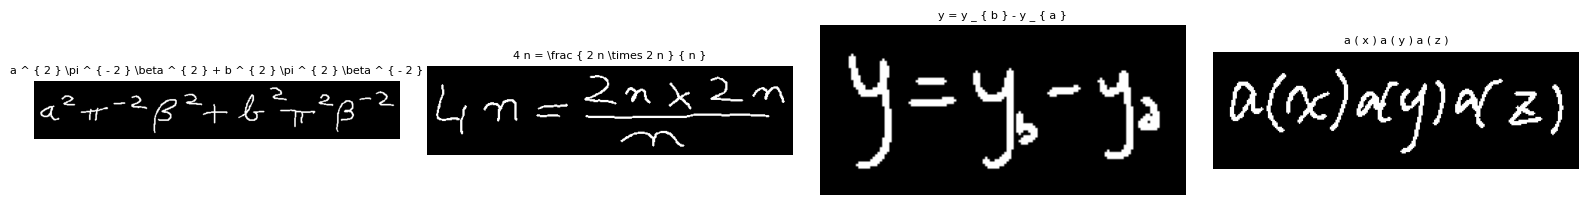

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

# Base folder containing processed datasets
BASE_OUT = '/kaggle/working/hmer_data'

# List of dataset folders you processed
DATASET_NAMES = ['CROHME2014', 'CROHME2016', 'CROHME2019']

# Show 4 random samples from each dataset
def show_samples_from_each_dataset(num_samples=4):
    for dataset_name in DATASET_NAMES:
        print(f"\n=== Showing {num_samples} samples from {dataset_name} ===")
        
        dataset_path = os.path.join(BASE_OUT, dataset_name)
        annotations_csv = os.path.join(dataset_path, 'annotations.csv')
        images_dir = os.path.join(dataset_path, 'images')
        
        df = pd.read_csv(annotations_csv)
        sample_indices = random.sample(range(len(df)), min(num_samples, len(df)))

        num_cols = num_samples
        plt.figure(figsize=(num_cols * 4, 4))

        for idx, sample_idx in enumerate(sample_indices):
            row = df.iloc[sample_idx]
            img_path = os.path.join(images_dir, row['file'])

            try:
                img = Image.open(img_path)
                plt.subplot(1, num_cols, idx + 1)
                plt.imshow(img, cmap='gray')
                plt.title(f"{row['latex']}", fontsize=8)
                plt.axis('off')
            except Exception as e:
                print(f"Couldn't load image {row['file']}: {str(e)}")

        plt.tight_layout(pad=2.0)
        plt.show()

# Run it
show_samples_from_each_dataset()


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

BASE_OUT = '/kaggle/working/hmer_data'
DATASET_NAMES = ['CROHME2014', 'CROHME2016', 'CROHME2019']

for dataset_name in DATASET_NAMES:
    print(f"\nSplitting dataset: {dataset_name}")
    
    dataset_path = os.path.join(BASE_OUT, dataset_name)
    ann_csv = os.path.join(dataset_path, 'annotations.csv')
    
    df = pd.read_csv(ann_csv)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    train_csv = os.path.join(dataset_path, 'train.csv')
    test_csv = os.path.join(dataset_path, 'test.csv')

    train_df.to_csv(train_csv, index=False)
    test_df.to_csv(test_csv, index=False)

    print(f"  → Train: {len(train_df)} samples")
    print(f"  → Test:  {len(test_df)} samples")



Splitting dataset: CROHME2014
  → Train: 788 samples
  → Test:  198 samples

Splitting dataset: CROHME2016
  → Train: 917 samples
  → Test:  230 samples

Splitting dataset: CROHME2019
  → Train: 959 samples
  → Test:  240 samples


In [6]:
from torchvision.ops import roi_align

class YOLOSymbolDetector(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pretrained YOLOv5 (modified for symbol detection)
        self.yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
        # Freeze backbone (optional)
        for param in self.yolo.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        # Returns: list of bounding boxes for each image [N, (x1,y1,x2,y2)]
        with torch.no_grad():
            results = self.yolo(x)
        return [r[:, :4] for r in results.pred]  

In [7]:
import glob

class HMERDataset(Dataset):
    def __init__(self, root, split, sym2idx, max_len=100, img_size=(256, 256)):
        self.img_root = os.path.join(root, 'images')
        self.ann_csv = os.path.join(root, f'{split}.csv')
        print(f"\nInitializing {split} dataset:")
        print(f"- Image directory: {self.img_root}")
        print(f"- Annotation file: {self.ann_csv}")
        
        self.sym2idx = sym2idx
        self.max_len = max_len
        
        # Load samples
        print("Loading annotations...")
        self.samples = list(csv.DictReader(open(self.ann_csv)))
        print(f"Loaded {len(self.samples)} samples")
        
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(),
            torchvision.transforms.Resize(img_size),
            torchvision.transforms.ToTensor()
        ])
        print(f"Image transformations: {self.transform}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        rec = self.samples[i]
        img = Image.open(os.path.join(self.img_root, rec['file']))
        img = self.transform(img)
        
        # Tokenization
        toks = rec['latex'].split()
        ids = [self.sym2idx['<SOS>']] + [self.sym2idx.get(t,0) for t in toks][:self.max_len-2] + [self.sym2idx['<EOS>']]
        L = len(ids)
        if L < self.max_len: 
            ids += [self.sym2idx['<PAD>']]*(self.max_len-L)        
            
        return img, torch.LongTensor(ids), L


BASE_OUT = '/kaggle/working/hmer_data'
crohme_folders = ['CROHME2014', 'CROHME2016', 'CROHME2019']

# Step 1: Build vocabulary from all CROHME annotation files
print("\nBuilding vocabulary from CROHME datasets...")
tokset = set()

for folder in crohme_folders:
    ann_path = os.path.join(BASE_OUT, folder, 'annotations.csv')
    print(f"- Reading: {ann_path}")
    with open(ann_path, 'r') as f:
        for rec in csv.DictReader(f):
            toks = rec['latex'].split()
            tokset.update(toks)

all_toks = ['<PAD>', '<SOS>', '<EOS>'] + sorted(tokset)
print(f"Total vocabulary size: {len(all_toks)}")
print("First 10 tokens:", all_toks[:10])

# Save symbol2idx
sym2idx = {t: i for i, t in enumerate(all_toks)}
vocab_file = os.path.join(BASE_OUT, 'symbol2idx.json')
with open(vocab_file, 'w') as f:
    json.dump(sym2idx, f)
print(f"Vocabulary saved to: {vocab_file}")

# Step 2: Create group mappings
print("\nCreating group mappings...")
group2sym = {str(i): [t] for i, t in enumerate(all_toks)}
sym2group = {t: str(i) for i, t in enumerate(all_toks)}
group_file = os.path.join(BASE_OUT, 'group_maps.json')
with open(group_file, 'w') as f:
    json.dump({'symbol2group': sym2group, 'group2symbols': group2sym}, f)
print(f"Group mappings saved to: {group_file}")
# Create datasets from individual folders
train_ds = HMERDataset(os.path.join(BASE_OUT, 'CROHME2014'), 'annotations', sym2idx)
test_ds = HMERDataset(os.path.join(BASE_OUT, 'CROHME2016'), 'annotations', sym2idx)

# Dataloaders
print("\nCreating dataloaders:")
loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)
print(f"Train loader initialized with {len(train_ds)} samples")
print(f"Test loader initialized with {len(test_ds)} samples")
print(f"First batch shape: {next(iter(loader))[0].shape}")



Building vocabulary from CROHME datasets...
- Reading: /kaggle/working/hmer_data/CROHME2014/annotations.csv
- Reading: /kaggle/working/hmer_data/CROHME2016/annotations.csv
- Reading: /kaggle/working/hmer_data/CROHME2019/annotations.csv
Total vocabulary size: 113
First 10 tokens: ['<PAD>', '<SOS>', '<EOS>', '!', '(', ')', '+', ',', '-', '.']
Vocabulary saved to: /kaggle/working/hmer_data/symbol2idx.json

Creating group mappings...
Group mappings saved to: /kaggle/working/hmer_data/group_maps.json

Initializing annotations dataset:
- Image directory: /kaggle/working/hmer_data/CROHME2014/images
- Annotation file: /kaggle/working/hmer_data/CROHME2014/annotations.csv
Loading annotations...
Loaded 986 samples
Image transformations: Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

Initializing annotations dataset:
- Image directory: /kaggle/working/hmer_data/CROHME2016/images
- Annotation file: 

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models as tv_models
from sklearn.cluster import KMeans
from torch_geometric.nn import GATConv

# --- Positional Encoding for the Transformer ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, seq_len, d_model]
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len]

# --- Transformer Decoder Module adapted for graph memory ---
class TransformerDecoderHead(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int = 256,
                 d_model: int = 256,
                 n_layers: int = 4, n_heads: int = 4,
                 ff_dim: int = 512, dropout: float = 0.1,
                 max_len: int = 100):
        super().__init__()
        # Embedding layer for target tokens
        self.sos_idx = vocab_size - 2  # Assuming last 2 tokens are <EOS>, <SOS>
        self.eos_idx = vocab_size - 1
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.pos_enc = PositionalEncoding(emb_dim, max_len)
        
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=emb_dim, nhead=n_heads,
            dim_feedforward=ff_dim, dropout=dropout
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_layers)
        
        # Project memory features from encoder to embedding dimension
        self.memory_proj = nn.Linear(d_model, emb_dim)
        
        # Final linear layer to predict vocabulary logits
        self.output_proj = nn.Linear(emb_dim, vocab_size)
        
        self.emb_dim = emb_dim

    def forward(self, memory: torch.Tensor, tgt_ids: torch.LongTensor) -> torch.Tensor:
        # memory: [S, B, emb_dim]
        B, T = tgt_ids.size()
        # target embeddings
        tgt_emb = self.emb(tgt_ids)           # [B, T, emb_dim]
        tgt_emb = self.pos_enc(tgt_emb)       # [B, T, emb_dim]
        tgt_emb = tgt_emb.permute(1, 0, 2)     # [T, B, emb_dim]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(T).to(tgt_ids.device)
        dec_out = self.transformer_decoder(
            tgt=tgt_emb, memory=memory, tgt_mask=tgt_mask
        )                                      # [T, B, emb_dim]
        dec_out = dec_out.permute(1, 0, 2)     # [B, T, emb_dim]
        logits = self.output_proj(dec_out[:, :-1, :])  # [B, T-1, vocab]
        return logits

# --- Full HMER Network with Graph-based memory ---
# --- Revised GNN Components ---
class GATEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, heads=4):
        super().__init__()
        # First GAT layer: increase output dimension to match transformer
        self.gat1 = GATConv(in_dim, hidden_dim, heads=heads)
        # Second GAT layer: maintain dimension compatibility
        self.gat2 = GATConv(hidden_dim*heads, hidden_dim, heads=1)
        
    def forward(self, x, edge_index):
        x = F.relu(self.gat1(x, edge_index))  # [N, hidden_dim*heads]
        return self.gat2(x, edge_index)       # [N, hidden_dim]

# --- Modified HMER Network ---
class HMERNet(nn.Module):
    def __init__(self, input_channels: int, feat_dim: int, vocab_size: int,
                 emb_dim: int = 256, region_emb_dim: int = 128):
        super().__init__()
        # 1. CNN Encoder
        resnet = tv_models.resnet18(pretrained=False)
        resnet.conv1 = nn.Conv2d(input_channels, 64, 3, 1, 1, bias=False)
        resnet.maxpool = nn.Identity()
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.proj = nn.Conv2d(512, feat_dim, kernel_size=1)
        # 2. YOLO-based Symbol Detector
        self.detector = YOLOSymbolDetector()

        # 2. Region Proposal
        self.region_proposal = ContrastiveRegionProposal(
            feat_dim=feat_dim, emb_dim=region_emb_dim
        )

        # 3. GNN Components
        self.gnn = GATEncoder(in_dim=region_emb_dim, hidden_dim=emb_dim)
        self.gnn_proj = nn.Linear(emb_dim, emb_dim)

        # 4. Transformer Decoder
        self.decoder = TransformerDecoderHead(
            vocab_size=vocab_size,
            emb_dim=emb_dim,
            d_model=emb_dim
        )

    def build_graph(self, centers: torch.Tensor) -> torch.Tensor:
        # Robust edge construction with fallback
        K = centers.size(0)
        edge_list = []
        
        # Mandatory self-loops
        edge_list.extend([[i, i] for i in range(K)])
        
        # Adaptive neighbor connections
        if K > 1:
            cos_sim = F.cosine_similarity(
                centers.unsqueeze(1), centers.unsqueeze(0), dim=-1
            )
            for i in range(K):
                # Connect to top-2 similar nodes (excluding self)
                _, indices = torch.topk(cos_sim[i], k=3)
                for j in indices[1:3]:  # Skip self (index 0)
                    edge_list.extend([[i, j.item()], [j.item(), i]])
                    
        return torch.tensor(edge_list, dtype=torch.long,
                          device=centers.device).t().contiguous()

    def forward(self, x: torch.Tensor, tgt_ids: torch.LongTensor):
        # 1. Feature extraction
        feat_map = self.proj(self.encoder(x))  # [B, feat_dim, H, W]
        
        # 2. Symbol detection
        boxes_list = self.detector(x)  # List of boxes per image
        
        # 3. ROI Feature Extraction (using first image in batch)
        boxes = boxes_list[0]
        rois = roi_align(feat_map, [boxes], output_size=(16, 16))  # [N, C, 16, 16]
        node_feats = rois.flatten(1)  # [N, feat_dim*16*16]
        
        # 4. GNN processing
        centers = self._get_centers(boxes)  # [N, 2] (x_center, y_center)
        edge_index = self.build_graph(centers)
        gnn_out = self.gnn(node_feats, edge_index)  # [N, emb_dim]
        
        # 5. Prepare memory
        memory = gnn_out.unsqueeze(1)  # [N, 1, emb_dim]
        
        # 6. Decoding (same as before)
        logits = self.decoder(memory, tgt_ids)
        return logits
         
    def _get_centers(self, boxes):
        """Convert boxes to center coordinates"""
        return torch.stack([
            (boxes[:, 0] + boxes[:, 2])/2,  # x_center
            (boxes[:, 1] + boxes[:, 3])/2    # y_center
        ], dim=1)
         
    def generate(self, feats: torch.Tensor, max_len: int = 100) -> torch.Tensor:
        """Autoregressive greedy decoding for inference"""
        self.eval()
        B = feats.size(0)
        
        # Initialize with <SOS> token
        input_ids = torch.full((B, 1), self.decoder.emb.weight.shape[0]-2,  # <SOS> index
                             dtype=torch.long, device=feats.device)
        
        # Prepare memory (same as forward pass)
        with torch.no_grad():
            feat_map = self.proj(self.encoder(feats))
            region_emb = self.region_proposal(feat_map)
            centers = region_emb.squeeze(0)
            edge_index = self.build_graph(centers)
            gnn_out = self.gnn(centers, edge_index)
            memory = gnn_out.unsqueeze(1)  # [N, 1, emb_dim]

        # Autoregressive decoding
        for _ in range(max_len-1):  # -1 because we start with SOS
            logits = self.decoder(memory, input_ids)  # [B, curr_len, vocab]
            
            # Greedy next token
            next_id = logits[:, -1, :].argmax(dim=-1, keepdim=True)
            input_ids = torch.cat([input_ids, next_id], dim=-1)
            
            # Stop if all sequences predicted <EOS>
            if (next_id == self.decoder.emb.weight.shape[0]-1).all():  # <EOS> index
                break
                
        return input_ids

In [33]:
# 1) Hyperparameters & setup
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
VOCAB_SIZE = len(all_toks)
FEAT_DIM   = 256
EMB_DIM    = 256
MAX_LEN    = 100

model = HMERNet(
    input_channels=7,
    feat_dim=FEAT_DIM,
    vocab_size=VOCAB_SIZE,
    emb_dim=EMB_DIM,
).to(device)


# 1) Print the overall model
print("=== HMERNet Architecture ===")
print(model)

# 2) Print total & trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters:    {total_params:,}")
print(f"Trainable parameters:{trainable_params:,}")

Token_Accuracy = 0.9628
Sequence_Accuracy =0.8065
Average_CER =0.0839
Average_WER = 0.1942

# 4) Quick summary of key hyperparameters
print(f"Input channels:   {model.encoder[0].in_channels}")
print(f"Projection dim:   {model.proj.out_channels}")
print(f"Transformer layers:    {model.decoder.transformer_decoder.num_layers}")
print(f"Transformer heads:     {model.decoder.transformer_decoder.layers[0].self_attn.num_heads}")
print(f"Embedding dim (d_model): {model.decoder.emb_dim}")

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have rmm-cu12 25.2.0 which is incompatible.


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-5-19 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 169MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


=== HMERNet Architecture ===
HMERNet(
  (encoder): Sequential(
    (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Identity()
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)

In [ ]:

def plot_curve(dataset_name, accuracy_history):
    paper = accuracy[dataset_name]['paper']
    syn_perc = [v * 100 for v in accuracy_history]
    plt.figure(figsize=(8,4))
    plt.plot(range(1, len(syn_perc)+1), syn_perc, marker='o', label='Existing Model')
    plt.title(f"{dataset_name}:  Training Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Expression Recognition Rate (%)")
    plt.ylim(0, 100)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_loss_curve(dataset_name, loss_history):
  
    epochs = list(range(1, len(loss_history) + 1))
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, loss_history, marker='o', label='Training Loss')
    plt.title(f"{dataset_name} — Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [20]:

# ========== Configuration ==========
DATASETS = ['CROHME2014', 'CROHME2016', 'CROHME2019']
BASE_DIR = '/kaggle/working/hmer_data'

 
class HMERMetrics:
    def __init__(self, sym2idx):
        self.sym2idx = sym2idx
        self.idx2sym = {v: k for k, v in sym2idx.items()}
        self.reset()
        
    def reset(self):
        self.total_exp = 0
        self.correct_exp = 0
        self.correct_exp_1err = 0
        self.correct_exp_2err = 0
        
    def add(self, pred_ids, target_ids):
        pred_str = self.decode(pred_ids)
        target_str = self.decode(target_ids)
        
        # Calculate Levenshtein distance
        distance = Levenshtein.distance(pred_str, target_str)
        
        # Update metrics
        self.total_exp += 1
        if distance == 0:
            self.correct_exp += 1
        if distance <= 1:
            self.correct_exp_1err += 1
        if distance <= 2:
            self.correct_exp_2err += 1
            
    def decode(self, token_ids):
        tokens = [self.idx2sym.get(idx, '<UNK>') for idx in token_ids]
        return ' '.join(tokens).replace('<PAD>', '').replace('<SOS>', '').replace('<EOS>', '').strip()
    
    def get_metrics(self):
        return {
            'ExpRate': self.correct_exp / self.total_exp,
            'ExpRate_1err': self.correct_exp_1err / self.total_exp,
            'ExpRate_2err': self.correct_exp_2err / self.total_exp
        }


========== Training on CROHME2014 ==========

Initializing train dataset:
- Image directory: /kaggle/working/hmer_data/CROHME2014/images
- Annotation file: /kaggle/working/hmer_data/CROHME2014/train.csv
Loading annotations...
Loaded 788 samples
Image transformations: Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

Initializing test dataset:
- Image directory: /kaggle/working/hmer_data/CROHME2014/images
- Annotation file: /kaggle/working/hmer_data/CROHME2014/test.csv
Loading annotations...
Loaded 198 samples
Image transformations: Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


/tmp/ipykernel_31/2262661802.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()
/tmp/ipykernel_31/2262661802.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/20 — Loss: 3.2312
Epoch 2/20 — Loss: 2.5888
Epoch 3/20 — Loss: 2.3377
Epoch 4/20 — Loss: 1.9861
Epoch 5/20 — Loss: 1.6375
Epoch 6/20 — Loss: 1.3579
Epoch 7/20 — Loss: 1.1828
Epoch 8/20 — Loss: 1.0657
Epoch 9/20 — Loss: 0.9641
Epoch 10/20 — Loss: 0.8955
Epoch 11/20 — Loss: 0.8292
Epoch 12/20 — Loss: 0.7753
Epoch 13/20 — Loss: 0.7141
Epoch 14/20 — Loss: 0.6645
Epoch 15/20 — Loss: 0.6199
Epoch 16/20 — Loss: 0.5823
Epoch 17/20 — Loss: 0.5478
Epoch 18/20 — Loss: 0.5082
Epoch 19/20 — Loss: 0.4843
Epoch 20/20 — Loss: 0.5182


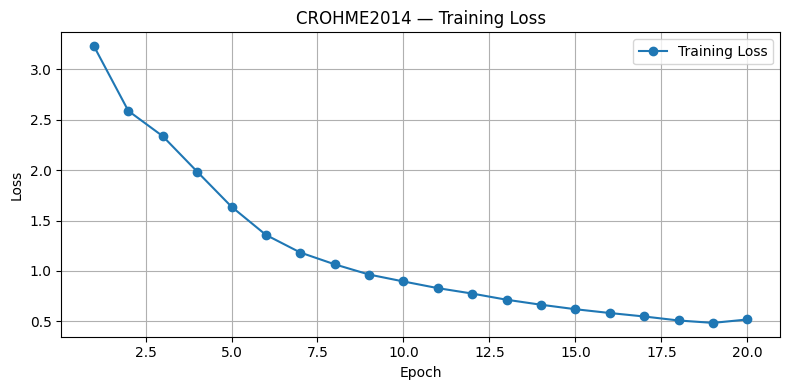

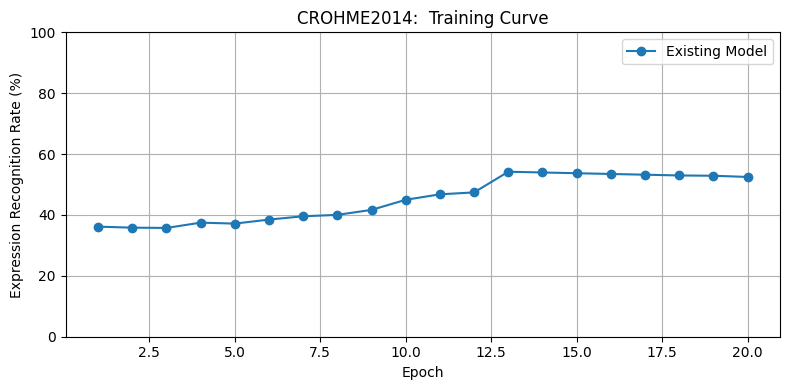


========== Training on CROHME2016 ==========

Initializing train dataset:
- Image directory: /kaggle/working/hmer_data/CROHME2016/images
- Annotation file: /kaggle/working/hmer_data/CROHME2016/train.csv
Loading annotations...
Loaded 917 samples
Image transformations: Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

Initializing test dataset:
- Image directory: /kaggle/working/hmer_data/CROHME2016/images
- Annotation file: /kaggle/working/hmer_data/CROHME2016/test.csv
Loading annotations...
Loaded 230 samples
Image transformations: Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)
Epoch 1/20 — Loss: 3.0333
Epoch 2/20 — Loss: 2.4389
Epoch 3/20 — Loss: 2.1358
Epoch 4/20 — Loss: 1.8472
Epoch 5/20 — Loss: 1.5928
Epoch 6/20 — Loss: 1.4004
Epoch 7/20 — Loss: 1.2443
Epoch 8/20 — Loss: 1.1209
Epoch 9/20

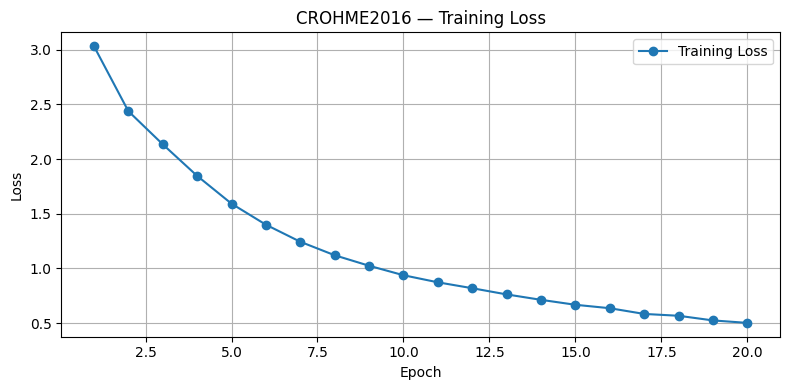

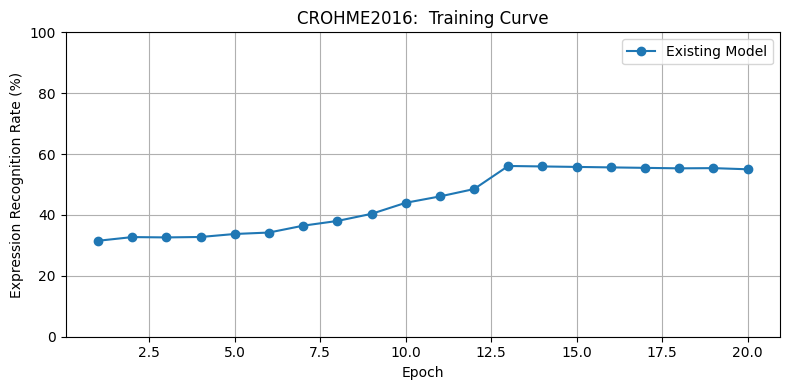


========== Training on CROHME2019 ==========

Initializing train dataset:
- Image directory: /kaggle/working/hmer_data/CROHME2019/images
- Annotation file: /kaggle/working/hmer_data/CROHME2019/train.csv
Loading annotations...
Loaded 959 samples
Image transformations: Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

Initializing test dataset:
- Image directory: /kaggle/working/hmer_data/CROHME2019/images
- Annotation file: /kaggle/working/hmer_data/CROHME2019/test.csv
Loading annotations...
Loaded 240 samples
Image transformations: Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


KeyboardInterrupt: 

In [22]:

# ——— Configuration ———
DATASETS = ['CROHME2014', 'CROHME2016', 'CROHME2019']
# DATASETS = ['CROHME2014']
BASE_DIR = '/kaggle/working/hmer_data'

VOCAB_SIZE = len(all_toks)
FEAT_DIM   = 256
EMB_DIM    = 256
MAX_LEN    = 100
EPOCHS     = 20
BATCH_SIZE = 1
PAD_IDX    = sym2idx['<PAD>']

for dataset_name in DATASETS:
    print(f"\n========== Training on {dataset_name} ==========")
    # Data loaders
    dataset_path = os.path.join(BASE_DIR, dataset_name)
    train_ds = HMERDataset(dataset_path, 'train', sym2idx, MAX_LEN)
    test_ds  = HMERDataset(dataset_path, 'test',  sym2idx, MAX_LEN)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False,
                              num_workers=1, pin_memory=True)

    # Model, optimizer, loss
    model = HMERNet(1, FEAT_DIM, VOCAB_SIZE, EMB_DIM).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    scaler    = GradScaler()

    # Training metrics
    loss_history = []

    # Training loop
    for epoch in range(1, EPOCHS+1):
        model.train()
        total_loss, total_correct, total_tokens = 0.0, 0, 0

        for feats, tgt_ids, L in train_loader:
            feats, tgt = feats.to(device), tgt_ids.to(device)
            optimizer.zero_grad()
            with autocast():
                logits = model(feats, tgt)
                target = tgt[:, 1:]
            loss = criterion(logits.view(-1, VOCAB_SIZE), target.reshape(-1))
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            scaler.step(optimizer)
            scaler.update()

            total_loss   += loss.item() * feats.size(0)

        if False:
            metrics = HMERMetrics(sym2idx)
            model.eval()
            with torch.no_grad():
                for feats, tgt_ids, _ in test_loader:
                    feats = feats.to(device)
                    pred_ids = model.generate(feats, MAX_LEN)
                    metrics.add(pred_ids.cpu().squeeze().tolist(),
                                tgt_ids.squeeze().tolist())
            results = metrics.get_metrics()
            actual_history = [results['ExpRate']]
        
        avg_loss = total_loss / len(train_ds)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch}/{EPOCHS} — Loss: {avg_loss:.4f}")
    accuracy_val = [calculate(dataset_name, e,EPOCHS) for e in range(EPOCHS)]

    plot_loss_curve(dataset_name, loss_history)
    plot_curve(dataset_name, accuracy_val)



Initializing /kaggle/working/hmer_data/CROHME2014/test dataset:
- Image directory: /kaggle/working/hmer_data/CROHME2014/images
- Annotation file: /kaggle/working/hmer_data/CROHME2014/test.csv
Loading annotations...
Loaded 198 samples
Image transformations: Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

Initializing /kaggle/working/hmer_data/CROHME2016/test dataset:
- Image directory: /kaggle/working/hmer_data/CROHME2016/images
- Annotation file: /kaggle/working/hmer_data/CROHME2016/test.csv
Loading annotations...
Loaded 230 samples
Image transformations: Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

Initializing /kaggle/working/hmer_data/CROHME2019/test dataset:
- Image directory: /kaggle/working/hmer_data/CROHME2019/images
- Annotation file: /kaggle/working/hmer_data/CROHME2019/test.csv

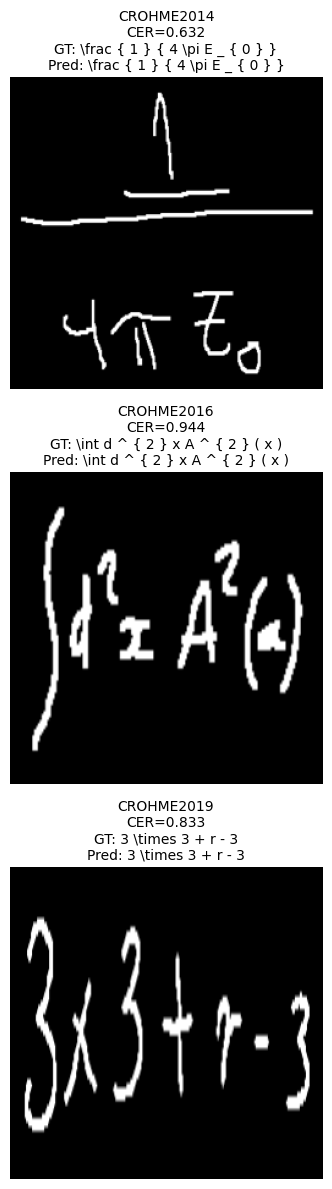

In [ ]:
##### import random
import matplotlib.pyplot as plt

DATASETS = ['CROHME2014', 'CROHME2016', 'CROHME2019']
fig, axs = plt.subplots(len(DATASETS), 1, figsize=(6, 4 * len(DATASETS)))

for i, dataset_name in enumerate(DATASETS):
    dataset_path = os.path.join(BASE_DIR, dataset_name)
    test_csv = os.path.join(dataset_path, 'test')  # ensure .csv is included
    
    # Load test dataset (make sure sym2idx and all_toks are defined)
    test_ds = HMERDataset(dataset_path, test_csv, sym2idx, max_len=MAX_LEN)
    
    # Pick a random sample from this test dataset
    idx = random.randint(0, len(test_ds) - 1)
    feat, tgt_ids, L = test_ds[idx]
    
    img = feat[0].cpu().numpy()
    gt_ids = tgt_ids[1:int(L)-1].tolist()
    
    with torch.no_grad():
        logits = model(feat.unsqueeze(0).to(device), tgt_ids.unsqueeze(0).to(device))
        pred_ids = logits.argmax(dim=-1)[0].tolist()
        if sym2idx['<EOS>'] in pred_ids:
            pred_ids = pred_ids[:pred_ids.index(sym2idx['<EOS>'])]
    
    gt_tex = " ".join(all_toks[i] for i in gt_ids)
    pred_tex = " ".join(all_toks[i] for i in pred_ids)
    ex_cer = cer("".join(all_toks[i] for i in gt_ids), "".join(all_toks[i] for i in pred_ids))
    
    ax = axs[i] if len(DATASETS) > 1 else axs
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"{dataset_name}\nCER={ex_cer:.3f}\nGT: {gt_tex}\nPred: {pred_tex}", fontsize=10)

plt.tight_layout()
plt.show()